# Tutorial 05 – Clustering

Clustering is a task of identifying clusters of similar data points in the dataset based on distances in feature space and assigning them cluster label. It is very often computed on unlabeled data and so it is an example of unsupervised technique. Because of unknown labels there is no single correct answer. In this tutorial we will cover 4 different clustering techniques, external and internal evaluation metrics and some other techniques. For more technical information and other algorithms see [scikit-learn documentation on clustering](https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods).

## Hierarchical Agglomerative Clustering (HAC)

The basic idea of HAC is to build clusters bottom up by unifying closest clusters into a single larger one. This process creates a hierarchy of clusters (dendrogram) and final clustering is obtained by making a 'cut' in the dendrogram.

Let's generate some dummy data to test agglomerative clustering. We will make three fairly well divided clusters.

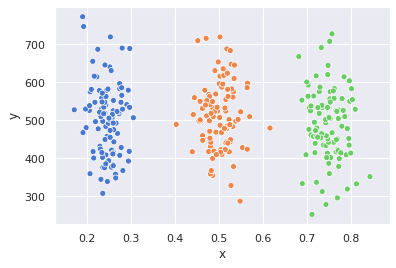

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set()  # make plots nicer

np.random.seed(42)  # set seed for reproducibility

data = pd.DataFrame(columns=["x", "y", "label"])  # prepare dataframe for datapoints

# generate three clusters
for i, mean_x in enumerate((0.25, 0.5, 0.75)):
    # generate some multivariate normal data
    x = np.random.normal(mean_x, 0.03, 100)
    y = np.random.normal(500, 100, 100)
    data = data.append(pd.DataFrame({"x": x, "y": y, "label": i}))


def plot_clusters(data, clusters):
    """
    Plots clusters using scatter plot and color them acordingly.
    
    :param pd.DataFrame data: dataframe with datapoints havig columns "x" and "y"
    :param list of int clusters: cluster label for each of the datapoint
    """
    # find outliers not belonging to any cluster (only relevant for DBSCAN)
    outlier_indices = clusters == -1

    # plot points and color them by cluster/label
    ax = sns.scatterplot(
        data=data[~outlier_indices],
        x="x",
        y="y",
        hue=clusters[~outlier_indices],
        palette="muted",
        legend=False,
    )

    if outlier_indices.any():
        ax = sns.scatterplot(
            data=data[outlier_indices], x="x", y="y", color="black", ax=ax
        )
    return ax


# examine the data
plot_clusters(data, data.label)

Now let's train a model and cluster the data.

In [7]:
from sklearn.cluster import AgglomerativeClustering

data_train = data.drop(columns=["label"])  # remove cluster label

ac = AgglomerativeClustering(n_clusters=3)  # try to find three clusters in the data
clusters = ac.fit_predict(data_train)  # save predicted clusters

Let's inspected clusters found by the model.

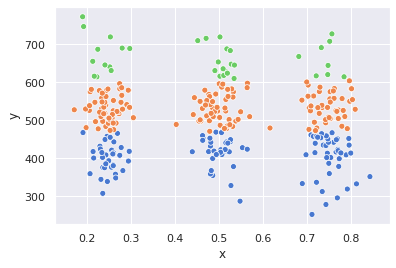

In [8]:
plot_clusters(data, clusters)

That clustering is really bad. All three clusters are mixed together. Its because we forgot to normalize features. Distances between points in y-axis are much larger than in x-axis.

<div class="alert alert-block alert-warning"><b>Exercise 1</b></div>

Make a pipeline that will scale both features into range [0, 1] and then run agglomerative clustering. If you did everything right, you should see the same clusters (except colors might be shuffled) as in the first figure.

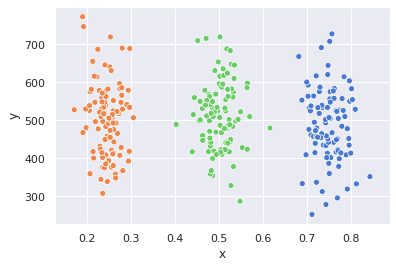

In [12]:
# pipeline = TODO: your code goes here...
# better_clusters = pipeline.fit_predict(X)
# plot_clusters(X, better_clusters)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler

pipeline = make_pipeline(MinMaxScaler(feature_range=(0,1)), AgglomerativeClustering(n_clusters=3))
better_clusters = pipeline.fit_predict(data_train)
plot_clusters(data_train, better_clusters)

This highlights importance of preprocessing before running clustering. It is also necessary to decide if and what scaling to use. Having features unscaled is equivalent to having weighted distance metric where features with higher larger absolute values (in our case y values) are more influential.

We can visualize the hierarchy of clusters (dendrogram). The height of the vertical lines is equivalent to 'distance' between two clusters being merged. If we cut at around height of 3, we get three clusters represented by tree different colors. These are exactly the clusters we see on figure above.

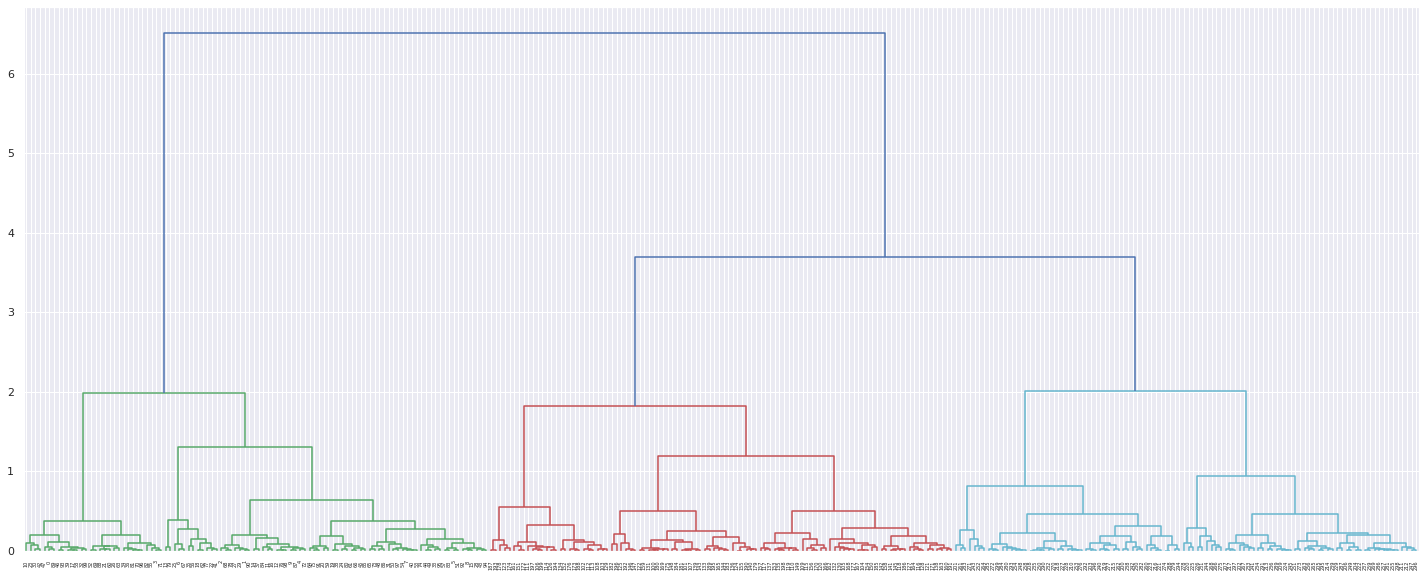

In [13]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

Z = linkage(pipeline[-2].fit_transform(data_train), "ward")
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z, distance_sort=True, color_threshold=3)

Now let's explore some real-life dataset and see what we can cluster. Let's load dataset about world flags. For each country, we have its basic information and then a lot of characterization of how the flag looks. 

In [14]:
flags = pd.read_csv("https://www.fi.muni.cz/~xcechak1/IB031/datasets/flags.csv")
flags.head(3)

,name,landmass,zone,area,population,religion,bars,stripes,colours,red,...,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright,country_code
0,Afghanistan,Asia,NE,648,16,Muslim,0,3,5,1,...,0,1,0,0,1,0,0,black,green,AF
1,Albania,Europe,NE,29,3,Marxist,0,0,3,1,...,0,1,0,0,0,1,0,red,red,AL
2,Algeria,Africa,NE,2388,20,Muslim,2,0,3,1,...,0,1,1,0,0,0,0,green,white,DZ


As usual, we need to convert categorical columns to category dtype.

In [15]:
object_columns = flags.select_dtypes(include="object")
flags[object_columns.columns] = object_columns.astype("category")

Now we can do the preprocessing and clustering. We will one-hot encode categorical values, standardize numeric values, and finally scale everything into range [0, 1]. We will use all features except country name and code as both are unique to each entry and landmass column will serve as true label.

In [16]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(), make_column_selector(dtype_include="category")),
        (StandardScaler(), ["area", "population"]),
        remainder="passthrough",
    ),
    MinMaxScaler(),
    AgglomerativeClustering(n_clusters=6),
)

flags_train = flags.drop(columns=["name", "country_code", "landmass"])
landmass = flags.landmass
flags_clusters = pipeline.fit_predict(flags_train)

Now we would like to gain insight into what clusters were actually found. We cannot plot the data in a straight forward scatter plot as they have many dimensions. Luckily, we can reduce the dimensionality using Principal Component Analysis (PCA) we saw in tutorial 01. PCA will project the data into given number of dimensions (2 in our case) and retain as much variation in the data as possible.

In [17]:
from sklearn.decomposition import PCA

pca_pipeline = make_pipeline(pipeline[:-1], PCA(n_components=2),)
flags_pca = pca_pipeline.fit_transform(flags_train)

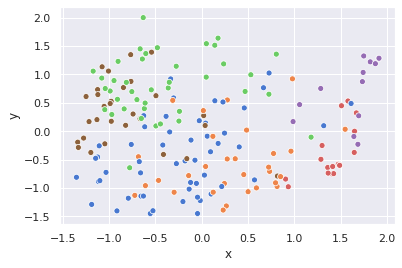

In [18]:
flags_pca = pd.DataFrame(flags_pca, columns=["x", "y"])
plot_clusters(flags_pca, flags_clusters)

This is still a but abstract, let's add country flags. First download the archive [flags.zip](https://www.fi.muni.cz/~xcechak1/IB031/assets/flags.zip) with country flags and extract the folder `flags` into the directory with this notebook. Then you should see scatter plot with flags.

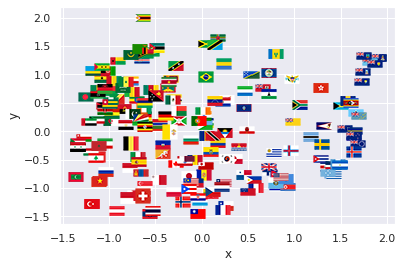

In [19]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage


def get_image(country_code):
    path = f"flags/{country_code.lower()}.png"
    return OffsetImage(plt.imread(path), zoom=1)


ax = plot_clusters(flags_pca, flags_clusters)
country_codes = flags.country_code.str.lower()
for x0, y0, country_code in zip(flags_pca.x, flags_pca.y, country_codes):
    ab = AnnotationBbox(get_image(country_code), (x0, y0), frameon=False)
    ax.add_artist(ab)

The projection did put similar looking flags closer to each other; mostly blue flags on the right, mostly red on the bottom, and mostly green in the top left corner. But the clusters were scatter around the plot, so let's see if how much they are consistent with `landmass`.

There are external metrics for evaluation of clustering with known labels. We will use Adjusted Rand index, Adjusted Mutual Information, and V-measure. All three measures are measuring 'agreement' between the two labelings. You can read more on these measure and their mathematical formulation in [scikit-learn documentation](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation).

<div class="alert alert-block alert-warning"><b>Exercise 2</b></div>

Evaluate clusters found in flags using Adjusted Rand Index, Adjusted Mutual Information and V-measure. Expected values of these scores are:
* ARI: 0.168
* AMI: 0.202
* V-measure: 0.236

In [24]:
# TODO: your code goes here...
from sklearn import metrics

print(metrics.adjusted_rand_score(flags.landmass, flags_clusters))
print(metrics.adjusted_mutual_info_score(flags.landmass, flags_clusters))
print(metrics.v_measure_score(flags.landmass, flags_clusters))

0.16848018409782892
0.20211396165863446
0.23598116002359154


## K means

K means algorithm relies on iterative optimization of cluster centroids. Initial centroids are selected randomly a therefore it usually needs multiple restarts or sophisticated centroid initialization to find something closer to global optimum. On the other hand, it is quite fast and simple.

Let's load another synthetic dataset and try out k means.

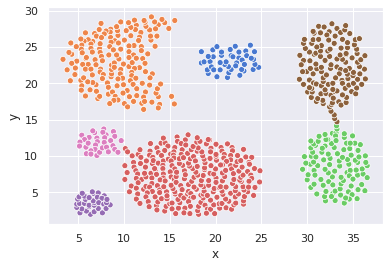

In [25]:
aggregation = pd.read_csv(
    "https://www.fi.muni.cz/~xcechak1/IB031/datasets/aggregation.csv"
)
plot_clusters(aggregation, aggregation.label)

Below is the example of randomness of k means algorithm. The default implementation in `scikit-learn` will restart the algorithm 10 times and select clusters from the best performing run.

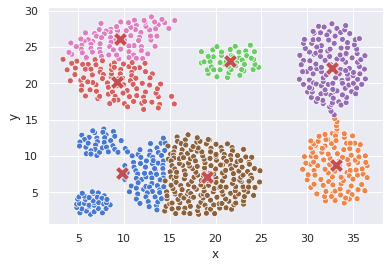

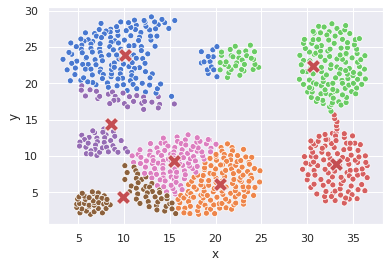

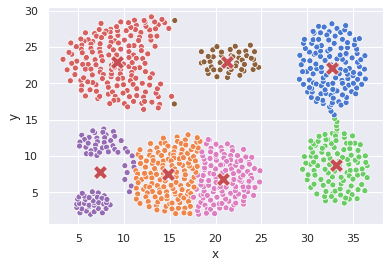

In [26]:
from sklearn.cluster import KMeans

aggregation_train = aggregation.drop(columns="label")

# three runs with different random seed
for i in range(3):
    # set random state and only one run
    kmeans = KMeans(n_clusters=7, random_state=i, n_init=1)
    clusters = kmeans.fit_predict(aggregation_train)

    plot_clusters(aggregation, clusters)
    # plot centroids
    sns.scatterplot(
        x=kmeans.cluster_centers_[:, 0],
        y=kmeans.cluster_centers_[:, 1],
        marker="X",
        color="r",
        s=200,
    )
    plt.show()

Red crosses indicate final centroids of the clusters. Different random states (and by extension centroid initializations) result in different clusters.

Now the algorithm needs to select the best clustering of different runs. It does not, however, have any ground truth labels for comparison. This is also the case in most clustering applications where we have data but no clear definition of clusters. We would like the clustering algorithm to give us some condense information of what is in the date, what clusters data points are present in the data.

To evaluate the clustering without any labels we need so called internal evaluation criteria. These are often based on judging cluster compactness (small within cluster distances) and separation (large between cluster distances). Examples of these measures are Silhouette Coefficient, Calinski-Harabasz index, and Davies-Bouldin index.

Since we do not have any ground truth labels we also do not know how many clusters should we be looking for. However, algorithms like K-means need to know the number of clusters in advance. Typical approach to navigate around this problem is to try different values of $k$ and then select the best performing one.

<div class="alert alert-block alert-warning"><b>Exercise 3</b></div>

Run K-means for values of $k$ ranging from 2 to 20 on `aggregation` dataset. Record Silhouette Coefficient, Calinski-Harabasz index, and Davies-Bouldin index for each value of $k$. Plot these measure values in relation to $k$ using line plot. Based on the plots and measure values decide what should be the best number of clusters. This decision could be done using [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) or looking for value of $k$ that maximize or minimize the measure value.

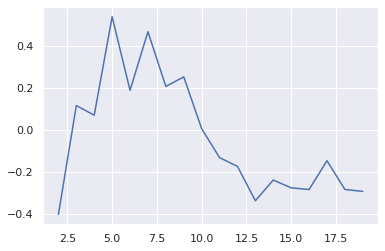

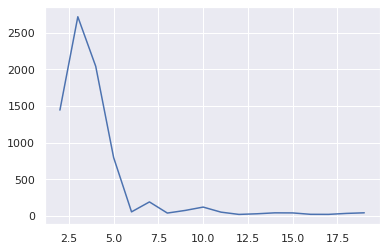

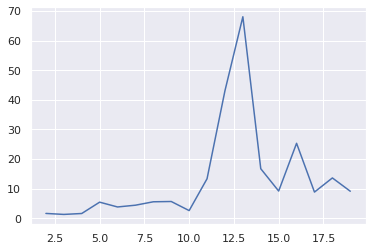

In [31]:
# TODO: your code goes here...
sils,calhars,davbous = [], [], []
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, random_state=i, n_init=1)
    clusters = kmeans.fit_predict(aggregation_train)
    sils.append(metrics.silhouette_score(clusters.reshape(-1, 1), aggregation.label))
    calhars.append(metrics.calinski_harabasz_score(clusters.reshape(-1, 1), aggregation.label))
    davbous.append(metrics.davies_bouldin_score(clusters.reshape(-1, 1), aggregation.label))
    
sns.lineplot(x = range(2,20), y = sils)
plt.show()
sns.lineplot(x = range(2,20), y = calhars)
plt.show()
sns.lineplot(x = range(2,20), y = davbous)
plt.show()

## Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

DBSCAN is one of the more sophisticated clustering techniques. Its basic idea is that clusters are areas with higher density of points separated by areas of lower densities. It has not assumption on cluster shapes (K-means expects convex clusters), does not need to specify number of clusters in advance (K-means needs number of clusters, HAC can cluster based on distance in tree), and is insensitive to outliers (K-means and HAC can be affected). You can read more on differences and advantages of DBSCAN in this [blog post](https://towardsdatascience.com/dbscan-clustering-for-data-shapes-k-means-cant-handle-well-in-python-6be89af4e6ea).

Let's demonstrate this advantages on another synthetic dataset.

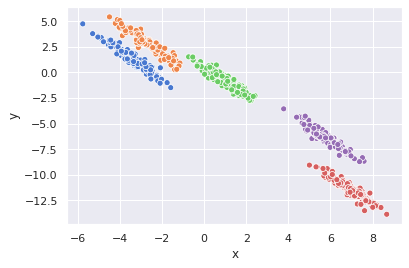

In [32]:
from sklearn.datasets import make_blobs

X, y = make_blobs(random_state=170, n_samples=600, centers=5)
np.random.seed(74)
transformation = np.random.normal(size=(2, 2))  # transform for streching the data
X = np.dot(X, transformation)  # transform points
diagonal = pd.DataFrame(X, columns=["x", "y"])
diagonal["label"] = y

plot_clusters(diagonal, diagonal.label)

Let's see how well K-Means and HAC are doing on this dataset.

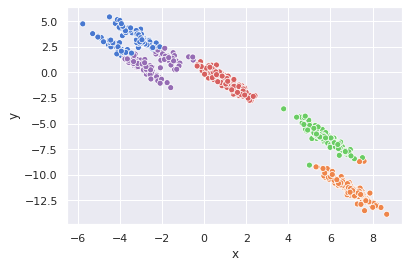

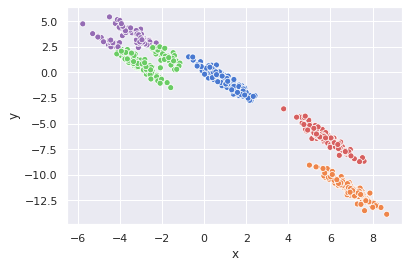

In [33]:
diagonal_train = diagonal.drop(columns="label")
km = KMeans(n_clusters=5)
km.fit(diagonal_train)

plot_clusters(diagonal, km.labels_)
plt.show()

hac = AgglomerativeClustering(n_clusters=5)
hac.fit(diagonal_train)
plot_clusters(diagonal, hac.labels_)

Notice that clusters in the upper left corner are incorrectly recognized in both cases. This type of clusters is tricky for HAC and K-means as 'ends' of the clusters are further apart than points between clusters.

<div class="alert alert-block alert-warning"><b>Exercise 4</b></div>

Find clusters in `diagonal` dataset using DBSCAN and plot them using `plot_clusters` function. The result should look like [this](https://www.fi.muni.cz/~xcechak1/IB031/assets/dbscan_diagonal.png).

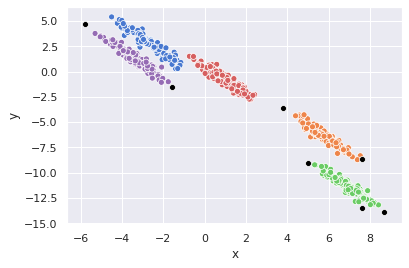

In [36]:
# TODO: your code goes here...
from sklearn.cluster import DBSCAN
dbscan = DBSCAN().fit(diagonal_train)
plot_clusters(diagonal, dbscan.labels_)

Here DBSCAN produced noticeably better result. Few black dots are "outliers" that do not belong to any cluster according to DBSCAN. However, it is not always this easy.

<div class="alert alert-block alert-warning"><b>Exercise 5</b></div>

Find clusters in `aggregation` dataset using DBSCAN and plot them using `plot_clusters` function.

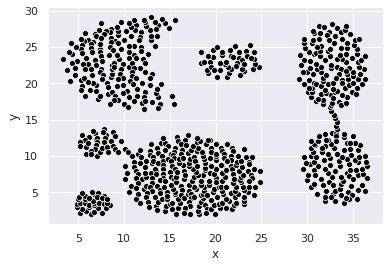

In [38]:
# TODO: your code goes here...
dbscan = DBSCAN().fit(aggregation_train)
plot_clusters(aggregation, dbscan.labels_)

That is not quite what we want. There are clearly clusters not just bunch of outliers. Big disadvantage of DBSCAN is its sensitivity to hyper parameter setting.

<div class="alert alert-block alert-warning"><b>Exercise 6</b></div>

Tweak DBSCAN's parameters so it identifies clusters correctly. Look into documentation for more info about each parameters function. Try to come close to the clustering in [this](https://www.fi.muni.cz/~xcechak1/IB031/assets/dbscan_aggregation.png).

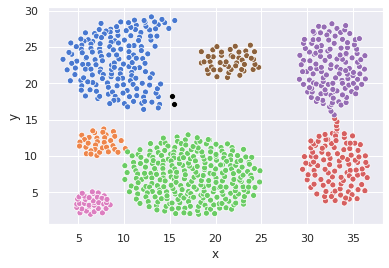

In [49]:
# TODO: your code goes here...
dbscan = DBSCAN(eps=1.4, min_samples=7).fit(aggregation_train)
plot_clusters(aggregation, dbscan.labels_)

### Gaussian Mixture

Gaussian mixture model fits gaussians ([generalization of gauss curve](https://en.wikipedia.org/wiki/Gaussian_function#Two-dimensional_Gaussian_function) to higher dimensions) for each cluster. Each point is then assign to cluster whose gaussian has the highest density at that point. This is of course a limiting factor (recall bias-variance trade-off) but it allows to model clusters that are separated by another cluster like the one below.

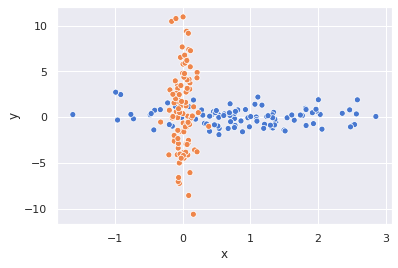

In [50]:
np.random.seed(42)

cross = pd.DataFrame()
x = np.random.normal(1, 1, 100)
y = np.random.normal(0, 1, 100)
cross = cross.append(pd.DataFrame({"x": x, "y": y, "label": 0}))

x = np.random.normal(0, 0.1, 100)
y = np.random.normal(0, 5, 100)
cross = cross.append(pd.DataFrame({"x": x, "y": y, "label": 1}))

plot_clusters(cross, cross.label)

<div class="alert alert-block alert-warning"><b>Exercise 7</b></div>

Fit GaussianMixture model on `cross` dataset and plot them using `plot_clusters` function. Observe that points on both sides of the vertical cluster belong to the same cluster.

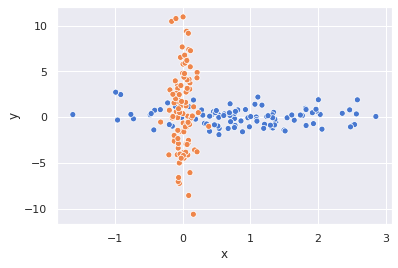

In [58]:
# gmm = ...
# TODO: your code goes here...
from sklearn.mixture import GaussianMixture
gaussian = GaussianMixture(n_components=2).fit_predict(cross)
plot_clusters(cross, gaussian)

This is because guassian for horizontal cluster is 'flatter' and has higher variance. So the density is still higher even for points to the left of the other cluster.

### Buckshot

<div class="alert alert-block alert-danger"><b>Exercise 8</b></div>

Implement Buckshot algorithm using AgglomerativeClustering and KMeans from `scikit-learn` and compare its performance on `aggregation` dataset to AgglomerativeClustering and KMeans. The description of the Buckshot algorithm is in the slides from lecture 4 on clustering.

In [ ]:
from sklearn.base import BaseEstimator, ClusterMixin


class BuckshotClustering(ClusterMixin, BaseEstimator):
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters

    def fit(self, X, y=None):
        # TODO: your code goes here...

        # technicality of framework
        # self.labels_ = final cluster labels
        return self


# TODO: your code goes here...